Anomalous Users:
             user  anomaly_score
5    DTAA/AAK0924      -0.033105
7    DTAA/AAS0709      -0.024478
8    DTAA/ABB0272      -0.068344
12   DTAA/ABL0836      -0.057573
13   DTAA/ABS0726      -0.034932
14   DTAA/ACD0647      -0.010431
15   DTAA/ACH0803      -0.000860
18   DTAA/ACR0400      -0.029779
21   DTAA/AEG0905      -0.016085
26   DTAA/AFH0331      -0.048604
27   DTAA/AFN0918      -0.004803
28   DTAA/AFO0022      -0.052331
33   DTAA/AGW0182      -0.022293
36   DTAA/AHV0103      -0.000435
37   DTAA/AIB0797      -0.057361
40   DTAA/AJA0220      -0.026570
41   DTAA/AJB0016      -0.035154
44   DTAA/AJC0266      -0.002028
47   DTAA/AJN0804      -0.023668
55   DTAA/AKS0283      -0.046205
65   DTAA/AMA0191      -0.096131
90   DTAA/ARS0993      -0.194585
109  DTAA/BAM0466      -0.004436
135  DTAA/BIR0534      -0.027773
138  DTAA/BJM0992      -0.196724
144  DTAA/BML0618      -0.038677
177  DTAA/CBB0075      -0.039014
183  DTAA/CBR0439      -0.034102
203  DTAA/CGM0994      -0.

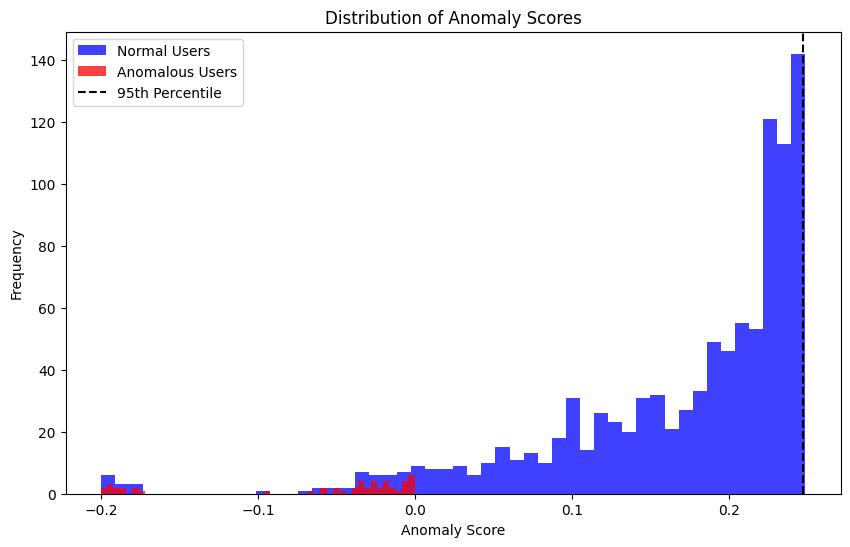

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Load logon data
logon_data = pd.read_csv('/content/r1/logon.csv')
logon_data['date'] = pd.to_datetime(logon_data['date'])
logon_data['hour'] = logon_data['date'].dt.hour
logon_data['after_hours'] = logon_data['hour'].apply(lambda x: 1 if x < 8 or x > 18 else 0)  # After-hours activity
logon_data['logon_count'] = logon_data.groupby('user')['user'].transform('count')  # Logon frequency

# Load device data
device_data = pd.read_csv('/content/r1/device.csv')
device_data['date'] = pd.to_datetime(device_data['date'])
device_data['thumb_drive_usage'] = device_data['activity'].apply(lambda x: 1 if x == 'connect' else 0)
device_data['thumb_drive_count'] = device_data.groupby('user')['thumb_drive_usage'].transform('sum')  # Thumb drive usage

# Load HTTP data
http_data = pd.read_csv('/content/r1/http.csv', header=None, names=['id', 'date', 'user', 'pc', 'url'])
http_data['date'] = pd.to_datetime(http_data['date'])
http_data['url_count'] = http_data.groupby('user')['url'].transform('count')  # URL visit frequency

# Load and process LDAP data
ldap_folder = '/content/r1/LDAP'
ldap_files = [os.path.join(ldap_folder, file) for file in os.listdir(ldap_folder) if file.endswith('.csv')]
ldap_data = pd.concat([pd.read_csv(file) for file in ldap_files], ignore_index=True)
ldap_data['role'] = ldap_data['Role'].apply(lambda x: 1 if x == 'IT Admin' else 0)  # Privileged users
ldap_data.rename(columns={'user_id': 'user'}, inplace=True)
ldap_data = ldap_data[['user', 'role']]
ldap_data.drop_duplicates(subset=['user'], inplace=True)

# Aggregate features per user
logon_agg = logon_data.groupby('user').agg(
    total_logons=('logon_count', 'max'),  # Total logons
    after_hours_logons=('after_hours', 'sum')  # After-hours logons
).reset_index()

device_agg = device_data.groupby('user').agg(
    thumb_drive_count=('thumb_drive_count', 'max')  # Total thumb drive usage
).reset_index()

http_agg = http_data.groupby('user').agg(
    url_count=('url_count', 'max')  # Total URLs visited
).reset_index()

# Merge all datasets on 'user'
merged_data = logon_agg.merge(device_agg, on='user', how='left')
merged_data = merged_data.merge(http_agg, on='user', how='left')
merged_data = merged_data.merge(ldap_data, on='user', how='left')

# Fill NaN values (e.g., users with no device or HTTP activity)
merged_data = merged_data.fillna(0)

# Feature Selection
features = [
    'total_logons', 'after_hours_logons', 'thumb_drive_count', 'url_count', 'role'
]
X = merged_data[features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination
iso_forest.fit(X_scaled)

# Predict anomalies
merged_data['anomaly_score'] = iso_forest.decision_function(X_scaled)
merged_data['is_anomaly'] = iso_forest.predict(X_scaled)

# Convert anomaly labels to binary (1 for anomaly, 0 for normal)
merged_data['is_anomaly'] = merged_data['is_anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Display anomalous users
anomalous_users = merged_data[merged_data['is_anomaly'] == 1]
print("Anomalous Users:")
print(anomalous_users[['user', 'anomaly_score']])

# Visualize anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(merged_data['anomaly_score'], bins=50, alpha=0.75, color='blue', label='Normal Users')
plt.hist(anomalous_users['anomaly_score'], bins=50, alpha=0.75, color='red', label='Anomalous Users')
plt.axvline(np.percentile(merged_data['anomaly_score'], 95), color='black', linestyle='--', label='95th Percentile')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.show()